In [59]:
import pandas as pd

#Load Data

In [60]:
df = pd.read_csv('cg.csv')
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Date          31 non-null     object
 1   Meet          31 non-null     object
 2   Grade         31 non-null     object
 3   Age           31 non-null     int64 
 4   Event         31 non-null     object
 5   Prelim/Final  31 non-null     object
 6   Place         31 non-null     object
 7   Time          31 non-null     object
dtypes: int64(1), object(7)
memory usage: 2.1+ KB
None
        Date                       Meet Grade  Age  Event Prelim/Final Place  \
0   3/3/2023            Border Olympics   9th   15  100mh      Prelims     2   
1   3/4/2023            Border Olympics   9th   15  100mh       Finals     2   
2  3/11/2023  Varsity City Invitational   9th   15  100mh       Finals     1   
3  3/24/2023    Laredo ISD Invitational   9th   15  100mh       Finals     1   
4  3/29/2023           

#Cleaning and preprocessing

In [61]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['Time'] = pd.to_numeric(df['Time'], errors='coerce')
df = df.dropna(subset=['Date', 'Time'])
df = df.sort_values('Date')
df = df.reset_index(drop=True)

#Z-Score Analysis for Anomalies

In [68]:
from scipy.stats import zscore

             #Z-score
df['Z_score'] = zscore(df['Time'])

anomalies = df[(df['Z_score'].abs() > 2)]
print("Anomalies (Z-score > 2 or < -2):")



print(anomalies[['Date',    'Time',    'Z_score']])


Anomalies (Z-score > 2 or < -2):
         Date   Time   Z_score
17 2024-04-10  17.78  3.092213


#Moving Average Calculation

In [70]:
df['Moving_Avg'] = df['Time'].rolling(window=3, center=True).mean()
print(df[['Date', 'Time', 'Moving_Avg']].head(10))


        Date   Time  Moving_Avg
0 2023-03-03  15.85         NaN
1 2023-03-04  16.54   16.026667
2 2023-03-11  15.69   16.073333
3 2023-03-24  15.99   15.883333
4 2023-03-29  15.97   15.673333
5 2023-04-21  15.06   15.450000
6 2023-04-23  15.32   15.220000
7 2023-04-24  15.28   15.623333
8 2024-02-09  16.27   15.793333
9 2024-02-09  15.83   16.146667


#Control Chart (X-bar chart) with Upper and Lower Control Limits



In [71]:
mean_time = df['Time'].mean()
std_time = df['Time'].std()


     # Define Control Limits (3-sigma)
df['Upper_CL'] = mean_time + 3 * std_time
df['Lower_CL'] = mean_time - 3 * std_time
print(f"Mean: {mean_time:.2f}, Std Dev: {std_time:.2f}")


Mean: 15.38, Std Dev: 0.79


#Cumulative Sum (CUSUM) for Positive and Negative Deviations

In [73]:
df['CUSUM_Pos'] = (df['Time'] - mean_time).cumsum().clip(lower=0)
df['CUSUM_Neg'] = (df['Time'] - mean_time).cumsum().clip(upper=0)
print(df[['Date', 'CUSUM_Pos', 'CUSUM_Neg']].head())


        Date  CUSUM_Pos  CUSUM_Neg
0 2023-03-03      0.472        0.0
1 2023-03-04      1.634        0.0
2 2023-03-11      1.946        0.0
3 2023-03-24      2.558        0.0
4 2023-03-29      3.150        0.0


#Trend Line (Linear Regression) to Identify Gradual Changes

In [74]:
import numpy as np
from sklearn.linear_model import LinearRegression

#    data for trend line
X = np.arange(len(df)).reshape(-1, 1)
y = df['Time'].values

model = LinearRegression().fit(X, y)
df['Trend_Line'] = model.predict(X)


print("Trend line coefficients:", model.coef_)
print("Trend line intercept:", model.intercept_)


Trend line coefficients: [-0.05826029]
Trend line intercept: 16.22277419354839


#Plotting the Visualizations

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns

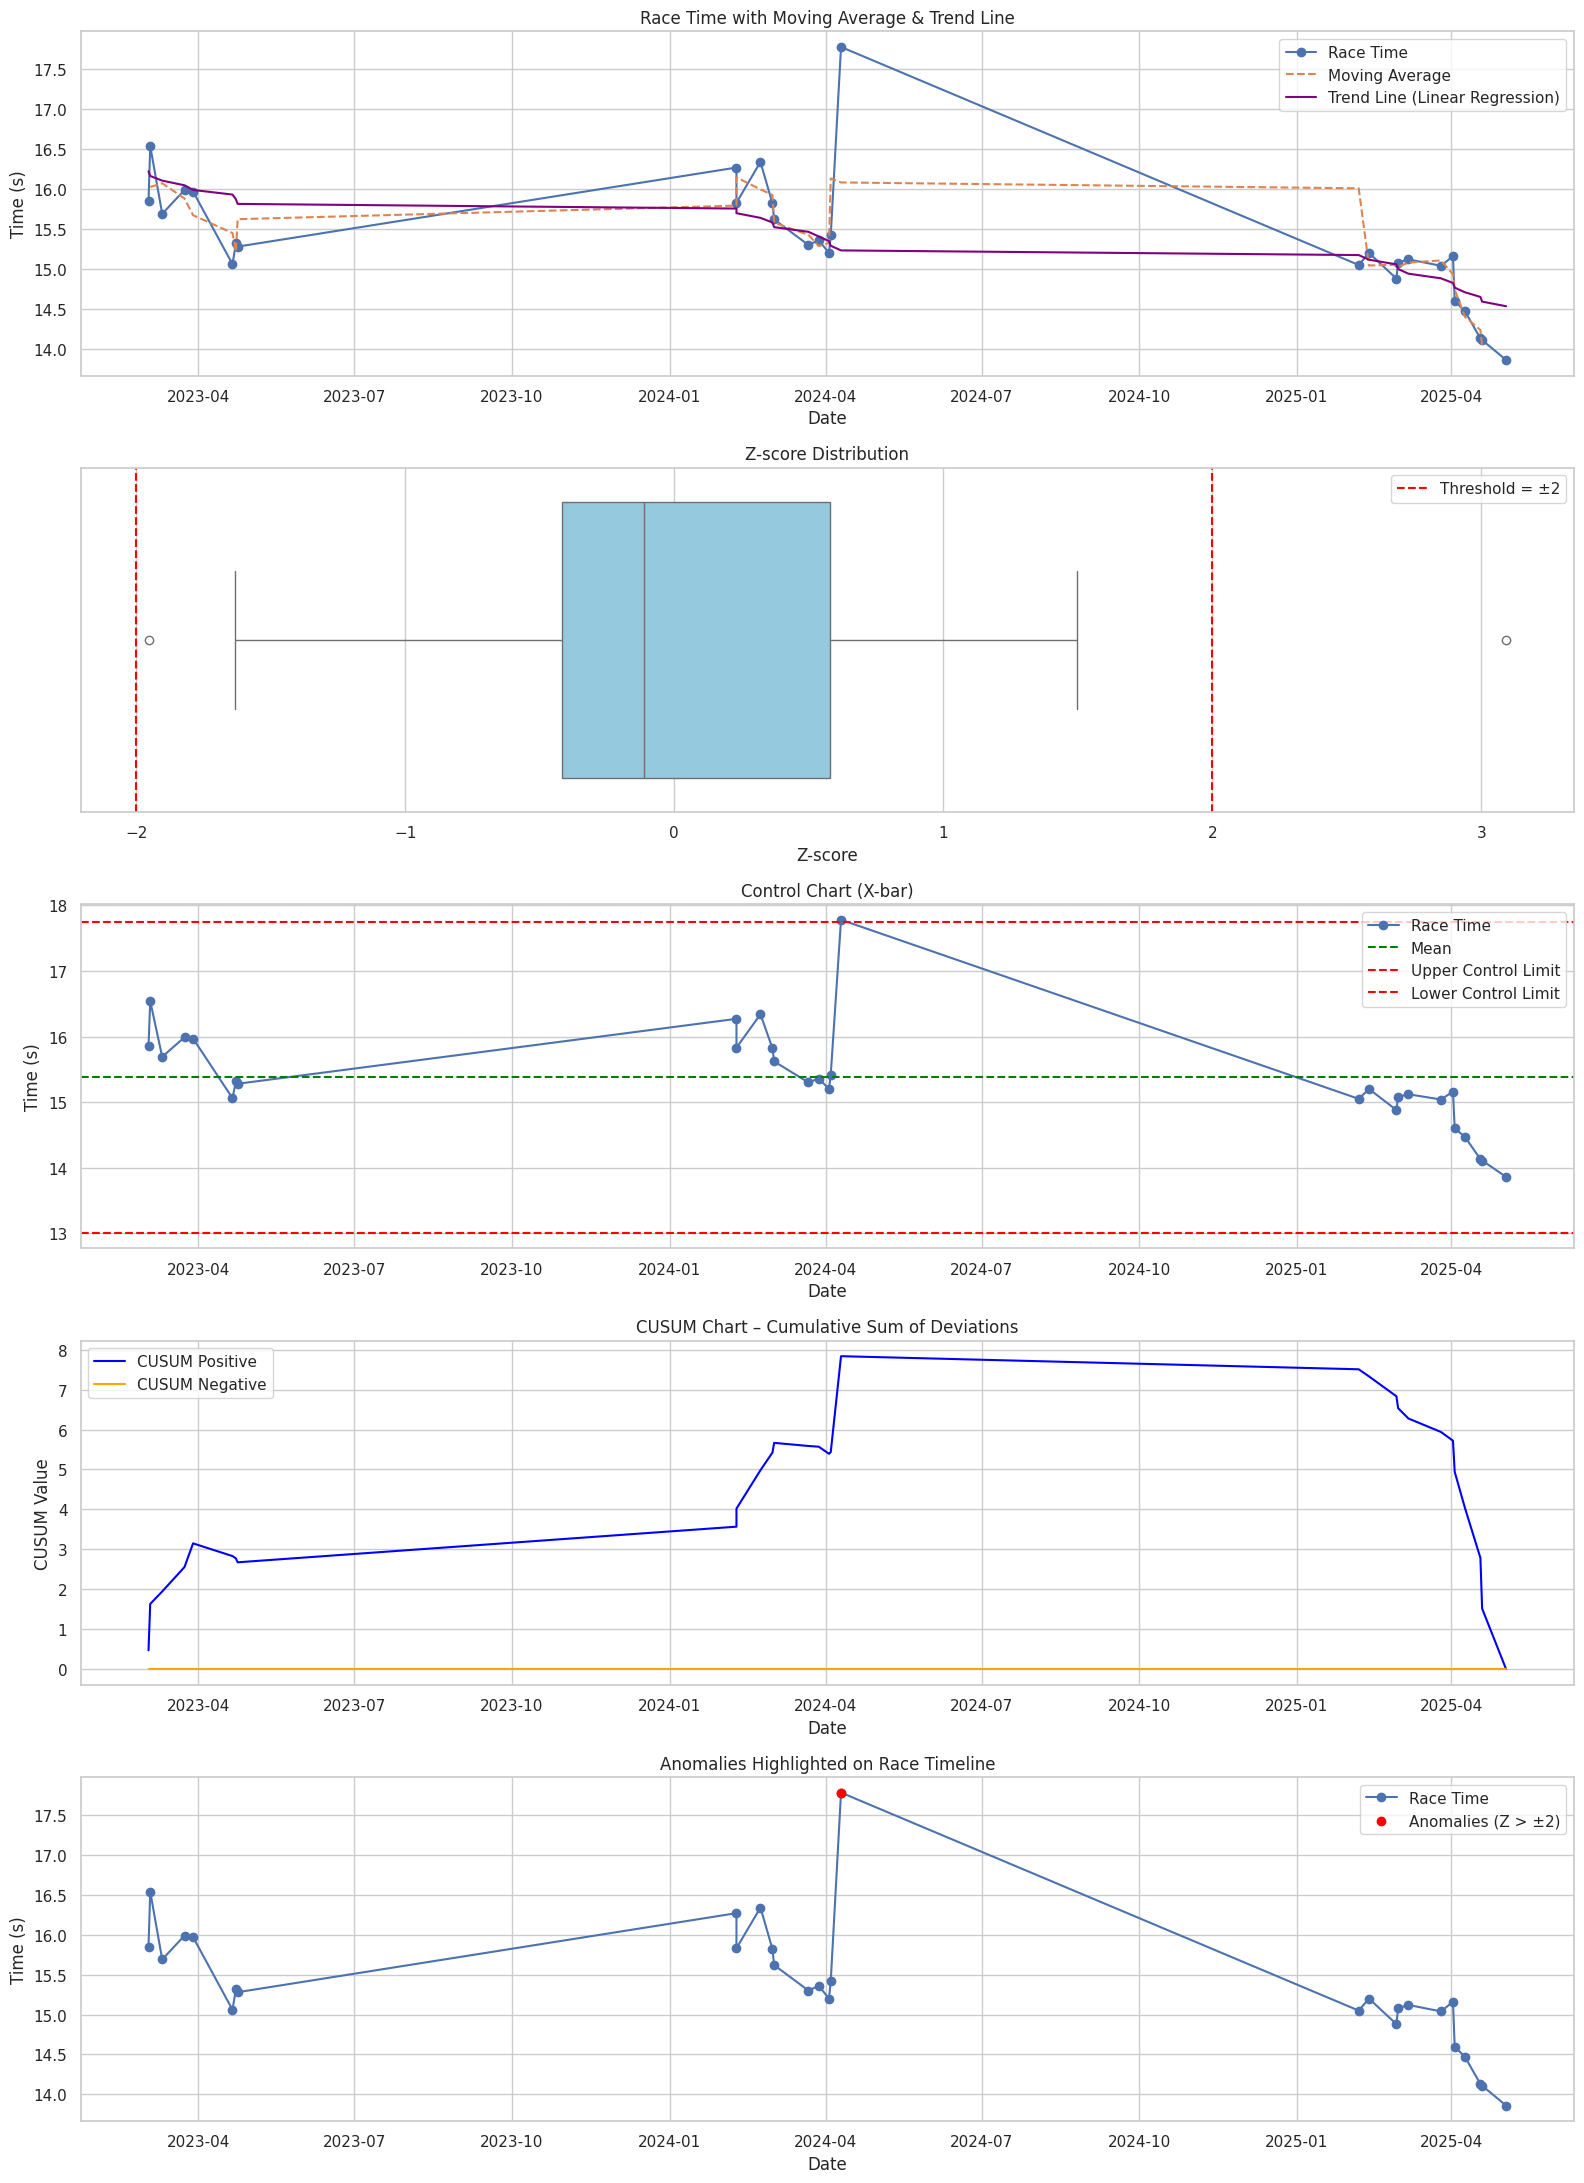

In [83]:
sns.set(style="whitegrid")
plt.figure(figsize=(16, 22))


                         #  Moving Average & Trend Line
plt.subplot(5, 1, 1)
plt.plot(df['Date'], df['Time'], marker='o', label='Race Time')
plt.plot(df['Date'], df['Moving_Avg'], label='Moving Average', linestyle='--')
plt.plot(df['Date'], df['Trend_Line'], label='Trend Line (Linear Regression)', color='purple')
plt.title('Race Time with Moving Average & Trend Line')
plt.xlabel('Date')
plt.ylabel('Time (s)')
plt.legend()
plt.grid(True)


                          #  Z-score Boxplot
plt.subplot(5, 1, 2)
sns.boxplot(x=df['Z_score'], color='skyblue', orient='h')
plt.axvline(2, color='red', linestyle='--', label='Threshold = ±2')
plt.axvline(-2, color='red', linestyle='--')
plt.title('Z-score Distribution')
plt.xlabel('Z-score')
plt.legend()

                        #Control Chart (X-bar)
plt.subplot(5, 1, 3)
plt.plot(df['Date'], df['Time'], marker='o', label='Race Time')
plt.axhline(mean_time, color='green', linestyle='--', label='Mean')
plt.axhline(df['Upper_CL'].iloc[0], color='red', linestyle='--', label='Upper Control Limit')
plt.axhline(df['Lower_CL'].iloc[0], color='red', linestyle='--', label='Lower Control Limit')
plt.title('Control Chart (X-bar)')
plt.xlabel('Date')
plt.ylabel('Time (s)')
plt.legend()

                       # 4. CUSUM Chart
plt.subplot(5, 1, 4)
plt.plot(df['Date'], df['CUSUM_Pos'], label='CUSUM Positive', color='blue')
plt.plot(df['Date'], df['CUSUM_Neg'], label='CUSUM Negative', color='orange')
plt.title('CUSUM Chart – Cumulative Sum of Deviations')
plt.xlabel('Date')
plt.ylabel('CUSUM Value')
plt.legend()

                    # 5. Anomalies Highlighted
plt.subplot(5, 1, 5)
plt.plot(df['Date'], df['Time'], marker='o', label='Race Time')
plt.scatter(anomalies['Date'], anomalies['Time'], color='red', label='Anomalies (Z > ±2)', zorder=5)
plt.title('Anomalies Highlighted on Race Timeline')
plt.xlabel('Date')
plt.ylabel('Time (s)')
plt.legend()


plt.tight_layout()
plt.savefig('performance_plots.png', dpi=300, bbox_inches='tight')
plt.show()
